Analytic solution: 2.048473
Numerical integration: 2.048473
Relative error: 0.00%


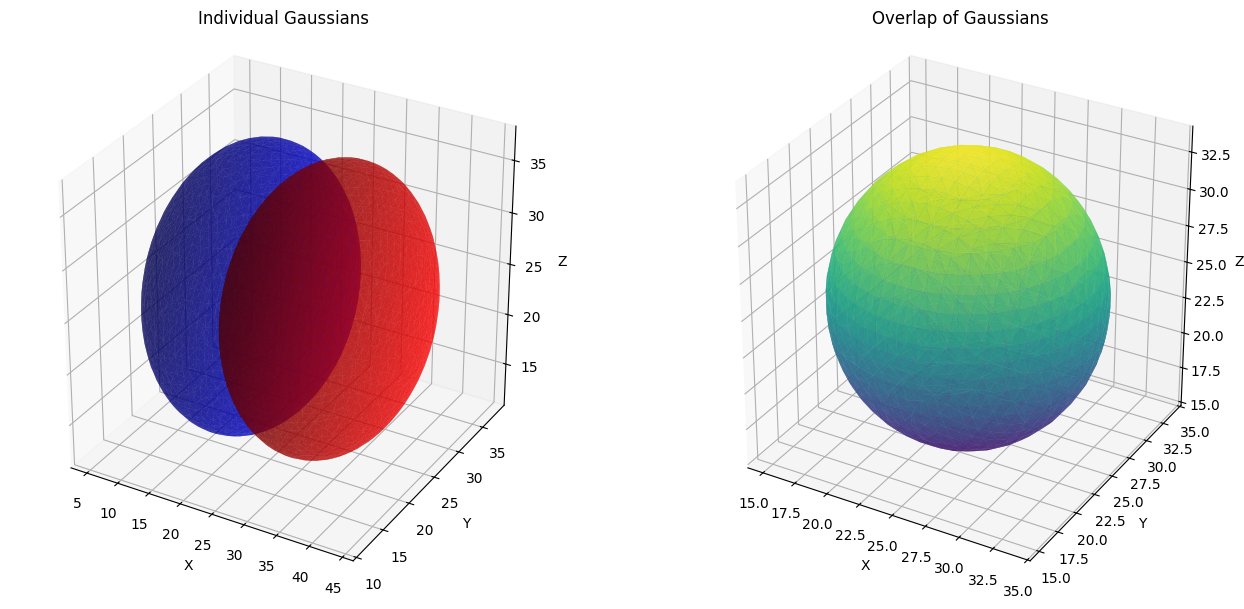

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection


# Its funny the code is reaaaaally simple :)
def gaussian_3d(r, center, A=1, sigma=1):
    return A * np.exp(-np.sum((r - center)**2) / (2 * sigma**2))

def analytic_overlap(A1, A2, d):
    return A1*A2*(np.pi)**(3/2)*np.exp(-d**2/4)

def numerical_overlap(A1, A2, r1, r2, sigma=1, limits=(-5,5)):
    def integrand(x, y, z):
        r = np.array([x, y, z])
        return gaussian_3d(r, r1, A1, sigma) * gaussian_3d(r, r2, A2, sigma)
    result, _ = nquad(integrand, [limits, limits, limits])
    return result

# Parameters
A1, A2 = 1, 1
r1 = np.array([-1, 0, 0])
r2 = np.array([1, 0, 0])
sigma = 1
d = np.linalg.norm(r1 - r2)

# Overlap Calculation
analytic = analytic_overlap(A1, A2, d)
numerical = numerical_overlap(A1, A2, r1, r2, sigma)
print(f"Analytic solution: {analytic:.6f}")
print(f"Numerical integration: {numerical:.6f}")
print(f"Relative error: {abs(analytic-numerical)/analytic*100:.2f}%")

# 3D Grid
grid_size = 50
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
z = np.linspace(-4, 4, grid_size)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
R = np.stack([X, Y, Z], axis=-1)

# Gaussian Values
G1 = A1 * np.exp(-np.sum((R - r1)**2, axis=-1) / (2 * sigma**2))
G2 = A2 * np.exp(-np.sum((R - r2)**2, axis=-1) / (2 * sigma**2))
G_overlap = G1 * G2

# Isosurfaces
iso_level1 = np.max(G1) * 0.1
iso_level2 = np.max(G2) * 0.1
iso_level_overlap = np.max(G_overlap) * 0.1

verts1, faces1, _, _ = marching_cubes(G1, level=iso_level1)
verts2, faces2, _, _ = marching_cubes(G2, level=iso_level2)
verts_overlap, faces_overlap, _, _ = marching_cubes(G_overlap, level=iso_level_overlap)

# Plotting
fig = plt.figure(figsize=(14, 6))

# --- Subplot 1: Gaussians ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(verts1[:, 0], verts1[:, 1], faces1, verts1[:, 2],
                 color='blue', alpha=0.6, lw=0.5, label='Gaussian 1')
ax1.plot_trisurf(verts2[:, 0], verts2[:, 1], faces2, verts2[:, 2],
                 color='red', alpha=0.6, lw=0.5, label='Gaussian 2')
ax1.set_title("Individual Gaussians")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_box_aspect([1,1,1])

# --- Subplot 2: Overlap ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(verts_overlap[:, 0], verts_overlap[:, 1], faces_overlap, verts_overlap[:, 2],
                 cmap='viridis', alpha=0.8, lw=0.5)
ax2.set_title("Overlap of Gaussians")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()

So we have the simple overlap formula: 

\begin{equation}
O = A_1 A_2 \pi^{3/2}*\exp(-d^2/2)
\end{equation}

Which gives us the derivative $\frac{dO}{dd} = \frac{-d}{2}O(d)$

Change in overlap volume: ΔO = -0.221799


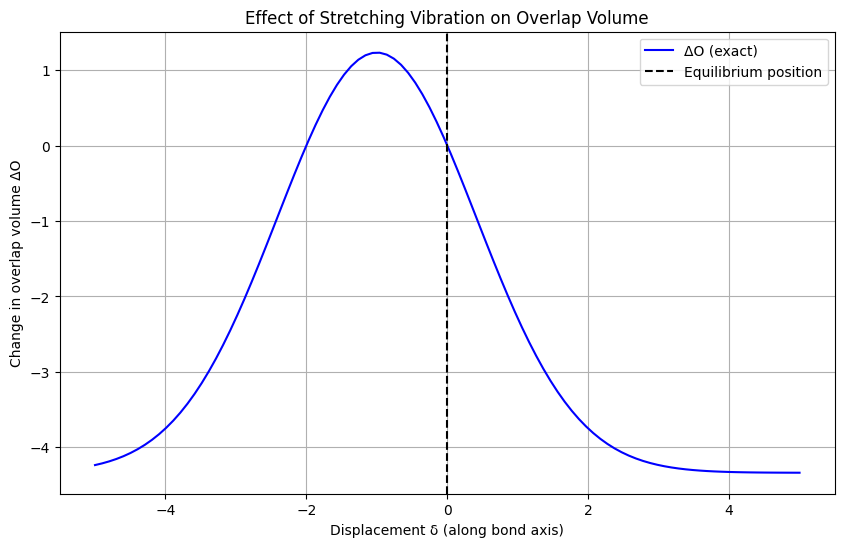

In [9]:
# I now simulate a kind of stretching vibration this is the simplest case we can consider, maybe bending is more complex im not sure jet
import numpy as np
import matplotlib.pyplot as plt

def overlap(d):
    """Analytical overlap formula (σ=1, A1=A2=1)."""
    return np.pi**(3/2) * np.exp(-d**2 / 4)

def stretching_vibration_effect(r1, r2_initial, delta):
    """
    Compute the exact change in overlap due to stretching displacement.
    
    Args:
        r1: Center of first Gaussian (fixed), shape (3,).
        r2_initial: Initial center of second Gaussian, shape (3,).
        delta: Scalar displacement along the bond axis (r2 - r1 direction).
    """
    d0 = np.linalg.norm(r2_initial - r1)
    d_new = d0 + delta  # Stretching along bond axis
    return overlap(d_new) - overlap(d0)

# Example: Stretching a bond along the x-axis
r1 = np.array([0.0, 0.0, 0.0])
r2_initial = np.array([1.0, 0.0, 0.0])  # Initial distance d0 = 1.0
delta = 0.1  # Displacement of +0.1 units (stretching)

delta_O = stretching_vibration_effect(r1, r2_initial, delta)
print(f"Change in overlap volume: ΔO = {delta_O:.6f}")

# Idea is to basically plot the change for different range of displacements
deltas = np.linspace(-5, 5, 100)  # Compression (-δ) and stretching (+δ)
delta_Os = [stretching_vibration_effect(r1, r2_initial, delta) for delta in deltas]

plt.figure(figsize=(10, 6))
plt.plot(deltas, delta_Os, 'b-', label="ΔO (exact)")
plt.axvline(x=0, color='k', linestyle='--', label="Equilibrium position")
plt.xlabel("Displacement δ (along bond axis)")
plt.ylabel("Change in overlap volume ΔO")
plt.title("Effect of Stretching Vibration on Overlap Volume")
plt.legend()
plt.grid()
plt.show()    

Ok this plot shows not the overlap volume for different displacments along the hypothetical bond axis.

So hypothetically we could do the following:

1. Maybe calculate the initial overlap volume before the displacement
2. compare this to the overlap volume after the displacement